# Imports 

In [1]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import mplfinance as mpf
import os
import matplotlib.ticker as  ticker

mt5.initialize(path = r'C:\Users\netinhoklz\AppData\Roaming\MetaTrader 5 - ActivTrades\terminal64.exe')
df = pd.DataFrame(mt5.copy_rates_range('TSLA.US', mt5.TIMEFRAME_M30, datetime.datetime(2020,1,1),datetime.datetime(2025,6,25)))
df['time'] = pd.to_datetime(df['time'], unit = 's') - datetime.timedelta(hours=6)
# df.set_index('time', inplace = True)
df

,time,open,high,low,close,tick_volume,spread,real_volume
0,2020-01-02 09:30:00,28.301,28.530,28.113,28.289,2624,3,0
1,2020-01-02 10:00:00,28.289,28.466,28.200,28.261,1959,3,0
2,2020-01-02 10:30:00,28.261,28.304,28.175,28.262,1328,3,0
3,2020-01-02 11:00:00,28.261,28.439,28.221,28.409,1346,3,0
4,2020-01-02 11:30:00,28.403,28.461,28.367,28.427,1527,3,0
...,...,...,...,...,...,...,...,...
17827,2025-06-24 13:30:00,342.100,343.230,341.140,341.310,2399,30,0
17828,2025-06-24 14:00:00,341.380,342.770,341.230,342.420,2247,30,0
17829,2025-06-24 14:30:00,342.430,343.290,341.740,343.120,2338,30,0
17830,2025-06-24 15:00:00,343.110,343.660,341.690,341.840,2248,30,0


# Funçoes

In [2]:
def eh_final_de_semana(data: datetime.date) -> bool:
  """
  Verifica se uma determinada data cai em um final de semana (sábado ou domingo).

  Args:
    data: Um objeto do tipo datetime.date.

  Returns:
    True se a data for um sábado ou domingo, False caso contrário.
  """
  # weekday() retorna 0 para segunda, 1 para terça, ..., 5 para sábado, 6 para domingo.
  # Portanto, se o dia da semana for maior ou igual a 5, é final de semana.
  return data.weekday() >= 5

# Base de dados negociaçao

In [3]:
trades = pd.read_csv('TSLA_backteste_treidando_apenas_nas_segundas_2020_01_01_ate_2025_06_15_meses_o4_mini_backteste1_PROMPT_RUIM.csv',sep = ';', index_col ='Unnamed: 0')
trades.columns = ['position', 'entry', 'gain', 'stop', 'justification', 'data', 'count']
trades

,position,entry,gain,stop,justification,data,count
0,aguardar,147.5,160.0,140.0,O preço está em fase de consolidação junto ao ...,2020_10_11,0
1,aguardar,152.0,162.0,147.0,O preço está em fase de consolidação lateraliz...,2020_10_18,0
2,aguardar,150.0,165.0,140.0,O papel está em fase de consolidação lateral a...,2020_10_25,0
3,aguardar,152.0,160.0,139.0,O preço opera próximo à média móvel de 20 perí...,2020_10_4,0
4,aguardar,138.0,150.0,130.0,O preço registrou uma forte queda e acabou rom...,2020_11_1,0
...,...,...,...,...,...,...,...
279,aguardar,320.0,360.0,305.0,Apesar da tendência de alta iniciada no fundo ...,2025_5_25,0
280,aguardar,280.0,300.0,270.0,O preço rompeu recentemente a região de conges...,2025_5_4,0
281,aguardar,330.0,380.0,310.0,O preço está encostando na banda superior de B...,2025_6_1,0
282,aguardar,335.0,360.0,305.0,O ativo ainda se encontra em fase de correção ...,2025_6_15,0


In [4]:
trades['position'].value_counts()

position
aguardar    193
comprar      72
vender       19
Name: count, dtype: int64

# Fazendo Backteste

In [5]:
import pandas as pd

def run_backtest(df: pd.DataFrame, trades: pd.DataFrame,
                 verbose: bool = True):
    """
    Executa um backtest (sem comissões) para ordens de COMPRA e VENDA com lógica de ORDEM LIMITE.
    O backtest utiliza dados intradiários (ex: 30 minutos) para maior precisão.
    O trade só é iniciado se o preço de entrada estiver dentro do range (mínima/máxima) de um candle.
    A SAÍDA do trade só pode ocorrer em um candle POSTERIOR ao candle de ENTRADA.
    A lógica de saída considera Stop Loss, Take Profit e Gaps de abertura.
    Sinais com posição 'aguardar' são ignorados.

    Args:
        df (pd.DataFrame): DataFrame com dados de mercado (time, open, high, low, close).
                           Para maior precisão, deve conter dados intradiários (ex: M30).
                           A coluna 'time' deve ser um datetime completo (com horas/minutos).
        trades (pd.DataFrame): DataFrame com as ordens (position, entry, gain, stop, data).
                               'position' pode ser 'compra', 'venda' ou 'aguardar'.
                               'data' é a data do SINAL, a execução será procurada APÓS essa data.
        verbose (bool): Se True, imprime um log detalhado de cada passo do backtest.
    """

    # --- ETAPA 1: PREPARAÇÃO DOS DADOS ---
    price_data = df.copy()
    signals_data = trades.copy()

    # <<-- ALTERAÇÃO 1: PREPARADO PARA DADOS INTRADIÁRIOS -->>
    # A conversão para datetime agora lida com o tempo (horas/minutos), não apenas a data.
    price_data['time'] = pd.to_datetime(price_data['time'])
    price_data.set_index('time', inplace=True)

    # A data do sinal continua sendo diária, o backtest procurará a entrada nos candles seguintes.
    signals_data['data'] = pd.to_datetime(signals_data['data'], format='%Y_%m_%d', errors='coerce')

    price_cols = ['entry', 'gain', 'stop']
    for col in price_cols:
        signals_data[col] = pd.to_numeric(signals_data[col], errors='coerce')

    signals_data.dropna(subset=['data', 'position', 'entry', 'gain', 'stop'], inplace=True)
    signals_data.rename(columns={'data': 'signal_date', 'gain': 'take_profit', 'stop': 'stop_loss'}, inplace=True)

    if signals_data.empty:
        print("Nenhum sinal válido encontrado no DataFrame 'trades'.")
        return pd.DataFrame()

    # --- ETAPA 2: EXECUÇÃO DO BACKTEST ---
    results_log = []

    for index, signal in signals_data.iterrows():
        if signal['position'] == 'aguardar':
            if verbose:
                print(f"\n{'='*20} [ORDEM #{index} IGNORADA] {'='*20}")
                print(f"Sinal do Dia: {signal['signal_date'].date()} | Posição: 'aguardar'. Nenhuma ação tomada.")
            continue 

        is_buy_trade = signal['position'] == 'comprar'

        if not is_buy_trade and signal['position'] != 'vender':
            if verbose:
                print(f"\n{'='*20} [ORDEM #{index} INVÁLIDA] {'='*20}")
                print(f"Sinal do Dia: {signal['signal_date'].date()} | Posição: '{signal['position']}' não reconhecida. Ignorando.")
            continue

        if verbose:
            print(f"\n{'='*25} [ORDEM #{index}] {'='*25}")
            print(f"Processando Ordem do Sinal de: {signal['signal_date'].date()}")
            position_type = "COMPRA" if is_buy_trade else "VENDA"
            print(f"  - Posição: {position_type}")
            print(f"  - Ordem de Entrada (Entry): {signal['entry']:.2f}")
            print(f"  - Alvo de Ganho (Gain): {signal['take_profit']:.2f} | Alvo de Perda (Stop): {signal['stop_loss']:.2f}")

        market_after_signal = price_data[price_data.index > signal['signal_date']]
        entry_timestamp, entry_price_real = None, 0

        # --- Loop para encontrar a ENTRADA (usando candles intradiários) ---
        if verbose: print("  - Procurando execução da ordem de entrada...")
        for current_timestamp, candle_data in market_after_signal.iterrows():
            if candle_data['low'] <= signal['entry'] <= candle_data['high']:
                entry_price_real = signal['entry']
                entry_timestamp = current_timestamp
                if verbose: 
                    print(f"  - >> ORDEM DE {position_type} EXECUTADA em {entry_timestamp.strftime('%Y-%m-%d %H:%M')}")
                    print(f"  -    Motivo: Preço de entrada ({signal['entry']:.2f}) está entre a Mínima ({candle_data['low']:.2f}) e a Máxima ({candle_data['high']:.2f}) do candle.")
                break

        if entry_timestamp is None:
            if verbose: print("  - >> ORDEM NÃO EXECUTADA. O preço nunca passou pelo ponto de entrada.")
            continue

        # --- Loop para encontrar a SAÍDA ---
        exit_price, exit_timestamp, exit_reason = 0, None, 'Not Exited'
        
        # <<-- ALTERAÇÃO 2: A BUSCA PELA SAÍDA COMEÇA NO CANDLE SEGUINTE AO DA ENTRADA -->>
        # Isso impede que a entrada e a saída ocorram no mesmo candle de 30 minutos.
        market_data_for_exit = market_after_signal[market_after_signal.index > entry_timestamp]

        if verbose: print("  - Procurando execução da ordem de saída (Gain/Stop)...")
        for current_timestamp, candle_data in market_data_for_exit.iterrows():
            if verbose: 
                log_time = current_timestamp.strftime('%Y-%m-%d %H:%M')
                print(f"    - Verificando candle de {log_time}: Open={candle_data['open']:.2f}, Low={candle_data['low']:.2f}, High={candle_data['high']:.2f}")

            if is_buy_trade:
                if candle_data['open'] <= signal['stop_loss']:
                    exit_price, exit_reason = candle_data['open'], 'Stop Gap'
                elif candle_data['low'] <= signal['stop_loss']:
                    exit_price, exit_reason = signal['stop_loss'], 'Stop Loss'
                elif candle_data['high'] >= signal['take_profit']:
                    exit_price, exit_reason = signal['take_profit'], 'Take Profit'
            else: # Lógica para 'venda'
                if candle_data['open'] >= signal['stop_loss']:
                    exit_price, exit_reason = candle_data['open'], 'Stop Gap'
                elif candle_data['high'] >= signal['stop_loss']:
                    exit_price, exit_reason = signal['stop_loss'], 'Stop Loss'
                elif candle_data['low'] <= signal['take_profit']:
                    exit_price, exit_reason = signal['take_profit'], 'Take Profit'
            
            if exit_reason != 'Not Exited':
                exit_timestamp = current_timestamp
                if verbose: print(f"  - >> SAÍDA: {exit_reason} em {exit_timestamp.strftime('%Y-%m-%d %H:%M')} ao preço de {exit_price:.2f}")
                break

        if exit_timestamp is None:
            last_candle_data = market_data_for_exit.iloc[-1]
            exit_price, exit_timestamp, exit_reason = last_candle_data['close'], last_candle_data.name, 'End of Data'
            if verbose: print(f"  - >> SAÍDA: Fim dos dados. Encerrado no fechamento de {exit_timestamp.strftime('%Y-%m-%d %H:%M')} a {exit_price:.2f}")

        # --- ETAPA 3: CÁLCULO FINAL DO RESULTADO (SEM COMISSÕES) ---
        exit_price_real = exit_price
        
        if is_buy_trade:
            dollar_gain = exit_price_real - entry_price_real
        else: # Sell trade
            dollar_gain = entry_price_real - exit_price_real
        
        result_pct_net = (dollar_gain / entry_price_real) if entry_price_real > 0 else 0

        results_log.append({
            'signal_date': signal['signal_date'],
            'position': signal['position'],
            'entry_date': entry_timestamp,
            'entry_price': entry_price_real,
            'exit_date': exit_timestamp,
            'exit_price': exit_price_real,
            'dollar_gain': dollar_gain,
            'stop_loss_target': signal['stop_loss'],
            'take_profit_target': signal['take_profit'],
            'result_pct_net': result_pct_net,
            'exit_reason': exit_reason
        })

    return pd.DataFrame(results_log)

if __name__ == '__main__':
    
    # <<-- MODIFICAÇÃO: Chamada da função sem o argumento de comissão -->>
    backtest_results = run_backtest(df, trades, verbose=True)

    print("\n\n" + "#" * 30 + " RESULTADO FINAL DO BACKTEST " + "#" * 30)
    if not backtest_results.empty:
        backtest_results['dollar_gain_fmt'] = backtest_results['dollar_gain'].apply(lambda x: f"${x:,.2f}")
        backtest_results['result_pct_net'] = backtest_results['result_pct_net'].apply(lambda x: f"{x:.2%}")

        display_cols = ['signal_date', 'position', 'entry_date', 'exit_date', 'entry_price', 'exit_price', 'dollar_gain_fmt', 'result_pct_net', 'exit_reason']
        print(backtest_results[display_cols])

        total_trades = len(backtest_results)
        win_rate = (backtest_results['dollar_gain'] > 0).sum() / total_trades
        total_dollar_gain = backtest_results['dollar_gain'].sum()
        
        print("\n--- MÉTRICAS GERAIS ---")
        print(f"Total de Trades Executados: {total_trades}")
        print(f"Taxa de Acerto (Trades com Ganho): {win_rate:.2%}")
        print(f"Ganho Total em Dólares: ${total_dollar_gain:,.2f}")
        print("\nContagem por Posição:")
        print(backtest_results['position'].value_counts())
        print("\nContagem de Saídas:")
        print(backtest_results['exit_reason'].value_counts())
    else:
        print("Nenhum trade foi executado. Verifique o log para detalhes.")
    print("#" * 80)


==================== [ORDEM #0 IGNORADA] ====================
Sinal do Dia: 2020-10-11 | Posição: 'aguardar'. Nenhuma ação tomada.

==================== [ORDEM #1 IGNORADA] ====================
Sinal do Dia: 2020-10-18 | Posição: 'aguardar'. Nenhuma ação tomada.

==================== [ORDEM #2 IGNORADA] ====================
Sinal do Dia: 2020-10-25 | Posição: 'aguardar'. Nenhuma ação tomada.

==================== [ORDEM #3 IGNORADA] ====================
Sinal do Dia: 2020-10-04 | Posição: 'aguardar'. Nenhuma ação tomada.

==================== [ORDEM #4 IGNORADA] ====================
Sinal do Dia: 2020-11-01 | Posição: 'aguardar'. Nenhuma ação tomada.

==================== [ORDEM #5 IGNORADA] ====================
Sinal do Dia: 2020-11-15 | Posição: 'aguardar'. Nenhuma ação tomada.

==================== [ORDEM #6 IGNORADA] ====================
Sinal do Dia: 2020-11-22 | Posição: 'aguardar'. Nenhuma ação tomada.

========================= [ORDEM #7] =========================
Processando 

# Capital Acumulado

In [6]:
backtest_results.sort_values('exit_date',inplace = True)
backtest_results.reset_index(inplace = True,drop = True)
backtest_results['resultado_acumulado'] = backtest_results['dollar_gain'].cumsum()
backtest_results

,signal_date,position,entry_date,entry_price,exit_date,exit_price,dollar_gain,stop_loss_target,take_profit_target,result_pct_net,exit_reason,dollar_gain_fmt,resultado_acumulado
0,2020-02-16,comprar,2020-02-25 10:00:00,54.0,2020-02-27 09:30:00,48.677,-5.323,50.0,62.0,-9.86%,Stop Gap,$-5.32,-5.323
1,2020-01-19,vender,2020-03-13 10:30:00,34.5,2020-03-13 12:30:00,36.000,-1.500,36.0,30.0,-4.35%,Stop Loss,$-1.50,-6.823
2,2020-01-12,vender,2020-03-16 10:00:00,32.0,2020-03-17 08:30:00,28.000,4.000,33.5,28.0,12.50%,Take Profit,$4.00,-2.823
3,2020-03-15,comprar,2020-04-09 09:30:00,38.0,2020-04-14 09:30:00,48.000,10.000,34.0,48.0,26.32%,Take Profit,$10.00,7.177
4,2020-07-12,vender,2020-07-13 15:30:00,100.0,2020-07-14 09:30:00,105.000,-5.000,105.0,90.0,-5.00%,Stop Loss,$-5.00,2.177
...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,2023-09-17,comprar,2025-02-28 09:30:00,275.0,2025-02-28 10:00:00,290.000,15.000,260.0,290.0,5.45%,Take Profit,$15.00,71.031
84,2024-10-13,vender,2025-03-10 12:30:00,225.0,2025-03-11 08:30:00,235.000,-10.000,235.0,200.0,-4.44%,Stop Loss,$-10.00,61.031
85,2025-03-23,comprar,2025-03-31 09:30:00,250.0,2025-04-02 11:30:00,280.000,30.000,230.0,280.0,12.00%,Take Profit,$30.00,91.031
86,2025-03-30,comprar,2025-04-02 11:30:00,280.0,2025-04-04 09:30:00,255.480,-24.520,260.0,335.0,-8.76%,Stop Gap,$-24.52,66.511


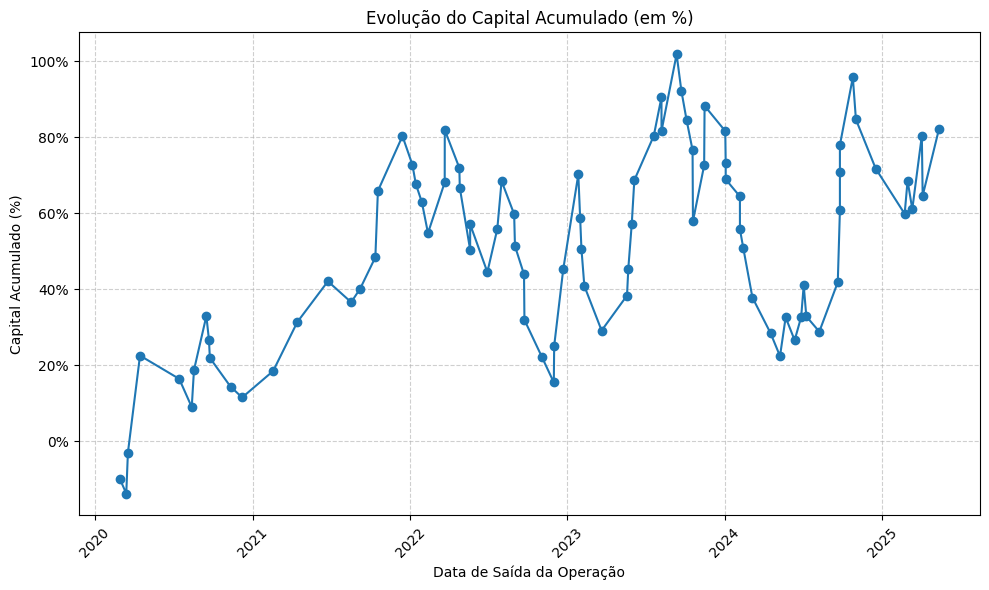

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import io


# Ler os dados para um DataFrame do pandas
df = backtest_results

# Converter a coluna de data e ordenar
df['exit_date'] = pd.to_datetime(df['exit_date'])
df = df.sort_values(by='exit_date')

# --- CALCULAR O PERCENTUAL ACUMULADO ---
# 1. Limpar a coluna de percentual e converter para número
df['result_pct_numeric'] = df['result_pct_net'].str.replace('%', '').astype(float) / 100

# 2. Calcular o fator de crescimento para cada operação (ex: 1.10 para +10%)
df['growth_factor'] = 1 + df['result_pct_numeric']

# 3. Calcular o produto acumulado e converter para o retorno percentual total
df['resultado_acumulado_pct'] = (df['growth_factor'].cumprod() - 1)

# --- PLOTAR O GRÁFICO ---
plt.figure(figsize=(10, 6))
plt.plot(df['exit_date'], df['resultado_acumulado_pct'], marker='o', linestyle='-')

# Formatar o eixo Y para mostrar o símbolo de percentual
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

# Adicionar títulos e rótulos
plt.title('Evolução do Capital Acumulado (em %)')
plt.xlabel('Data de Saída da Operação')
plt.ylabel('Capital Acumulado (%)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()

# Exibir o gráfico
plt.show()

--- Tabela de Cálculo Final ---

--- Resultado Final ---
Máximo Drawdown (MDD): 39.36%
Período do MDD - Início (índice): 53, Fim (índice): 68


C:\Users\netinhoklz\AppData\Local\Temp\ipykernel_12016\4034808897.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mdd_start_index = df.loc[:mdd_end_index][df['capital_acumulado'] == mdd_peak_value].index.max()


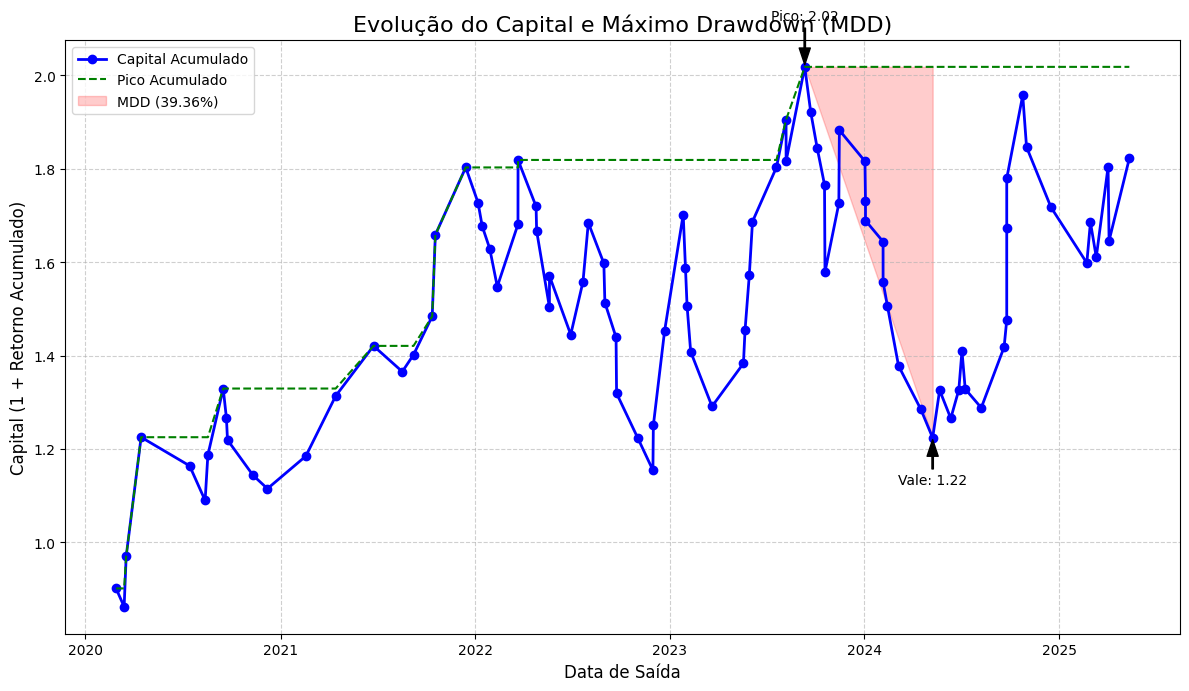

In [8]:
# --- 2. CÁLCULO DO RETORNO ACUMULADO ---
# Garante que as datas sejam do tipo datetime e ordena as operações cronologicamente
df['exit_date'] = pd.to_datetime(df['exit_date'])
df = df.sort_values(by='exit_date').reset_index(drop=True)

# Converte o percentual de string para numérico (ex: '8.66%' -> 0.0866)
df['result_pct_numeric'] = df['result_pct_net'].str.replace('%', '').astype(float) / 100

# Calcula o capital acumulado (1 + retorno acumulado)
df['capital_acumulado'] = (1 + df['result_pct_numeric']).cumprod()


# --- 3. CÁLCULO DO MÁXIMO DRAWDOWN (MDD) ---
# Calcula o valor máximo que o capital já atingiu até cada ponto
df['pico_acumulado'] = df['capital_acumulado'].cummax()

# Calcula o drawdown em cada ponto (diferença percentual entre o pico e o valor atual)
df['drawdown'] = (df['pico_acumulado'] - df['capital_acumulado']) / df['pico_acumulado']

# Encontra o valor do Máximo Drawdown
max_drawdown = df['drawdown'].max()

# Identifica os índices de início e fim do período de Máximo Drawdown (LÓGICA CORRIGIDA)
mdd_end_index = df['drawdown'].idxmax()
mdd_peak_value = df.loc[mdd_end_index, 'pico_acumulado']
mdd_start_index = df.loc[:mdd_end_index][df['capital_acumulado'] == mdd_peak_value].index.max()


# --- 4. EXIBIÇÃO DOS RESULTADOS ---
print("--- Tabela de Cálculo Final ---")
print("\n--- Resultado Final ---")
print(f"Máximo Drawdown (MDD): {max_drawdown:.2%}")
print(f"Período do MDD - Início (índice): {mdd_start_index}, Fim (índice): {mdd_end_index}")


# --- 5. VISUALIZAÇÃO GRÁFICA ---
fig, ax = plt.subplots(figsize=(12, 7))

# Plota as linhas de Capital Acumulado e Pico Acumulado
ax.plot(df['exit_date'], df['capital_acumulado'], label='Capital Acumulado', marker='o', color='blue', lw=2)
ax.plot(df['exit_date'], df['pico_acumulado'], label='Pico Acumulado', color='green', linestyle='--')

# Destaca a área do Máximo Drawdown
start_date = df.loc[mdd_start_index, 'exit_date']
end_date = df.loc[mdd_end_index, 'exit_date']
peak_val = df.loc[mdd_start_index, 'capital_acumulado']
trough_val = df.loc[mdd_end_index, 'capital_acumulado']

# Preenche a área do drawdown
ax.fill_between([start_date, end_date], [peak_val, peak_val], [peak_val, trough_val], color='red', alpha=0.2, label=f'MDD ({max_drawdown:.2%})')

# Adiciona anotações para o pico e o vale
ax.annotate(f'Pico: {peak_val:.2f}',
            xy=(start_date, peak_val),
            xytext=(start_date, peak_val + 0.1),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
            ha='center')
ax.annotate(f'Vale: {trough_val:.2f}',
            xy=(end_date, trough_val),
            xytext=(end_date, trough_val - 0.1),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
            ha='center')

# Configurações do gráfico
ax.set_title('Evolução do Capital e Máximo Drawdown (MDD)', fontsize=16)
ax.set_xlabel('Data de Saída', fontsize=12)
ax.set_ylabel('Capital (1 + Retorno Acumulado)', fontsize=12)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [9]:
capital_inicial = 10000
backtest_results['variacao_percentual'] = (backtest_results['dollar_gain']/backtest_results['entry_price']) + 1
valor_final_historico = [] 
for x in backtest_results['variacao_percentual']:
    capital_inicial = capital_inicial * x
    valor_final_historico.append(((capital_inicial/10000)-1)*100 )
backtest_results['resultado_percentual'] = valor_final_historico
capital_inicial

18228.49602474474

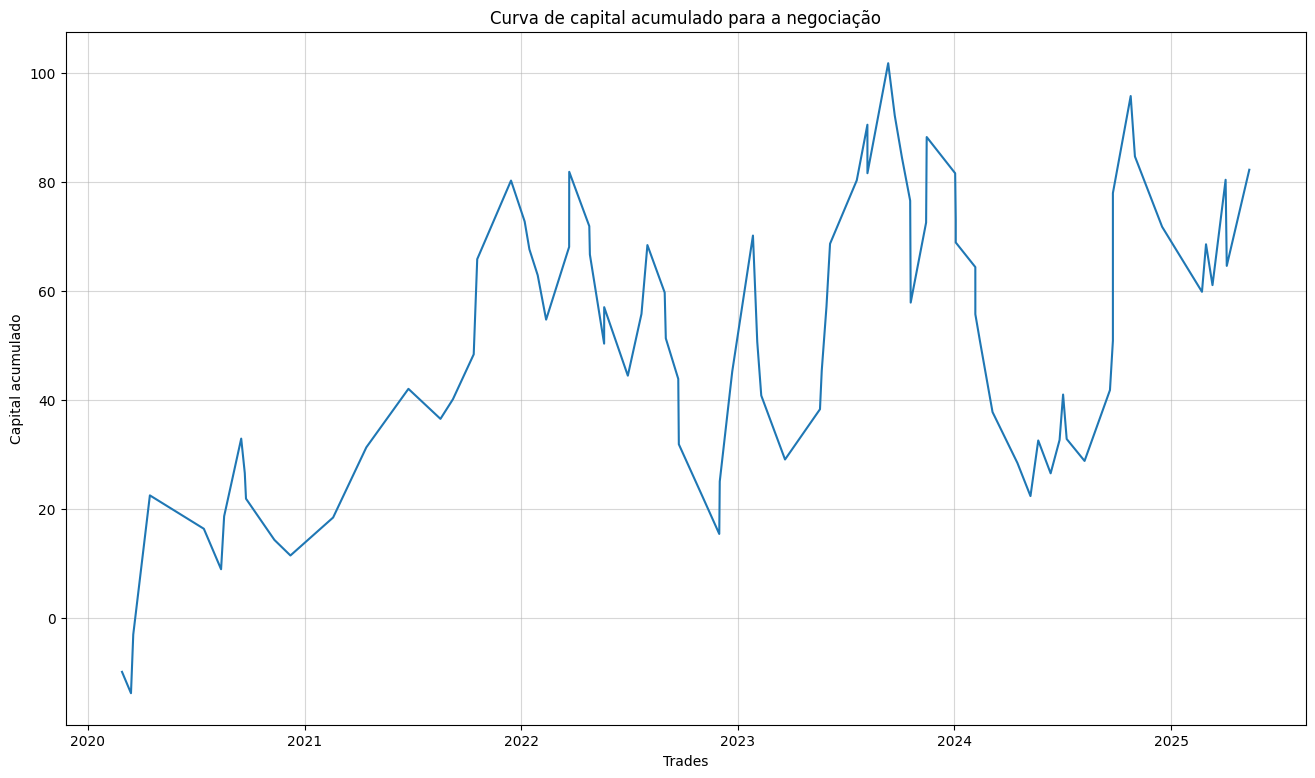

In [10]:
plt.figure(figsize = (16,9))
# plt.plot(backtest_results.exit_date,backtest_results['resultado_acumulado'])
plt.plot(backtest_results.exit_date,valor_final_historico)
plt.xlabel('Trades')
plt.ylabel('Capital acumulado')
plt.title('Curva de capital acumulado para a negociação')
plt.grid(alpha = 0.5)
plt.show()

NameError: name 'sp500' is not defined

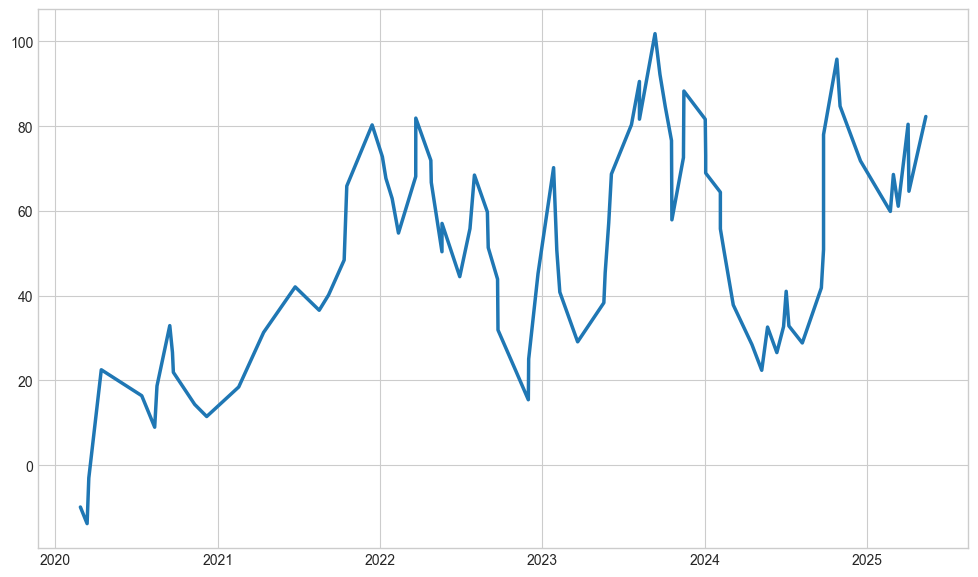

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates

# --- Configurações Iniciais (Assumindo que seus DataFrames já estão carregados) ---
# df_daily, backtest_results, sp500, nasdaque

# 1. ESTILO E CRIAÇÃO DA FIGURA
# Usar um estilo visual mais limpo e profissional. 'seaborn-v0_8-whitegrid' é uma ótima opção.
plt.style.use('seaborn-v0_8-whitegrid')

# Criar a figura e os eixos (ax). Usar subplots() dá mais controle.
# Aumentamos um pouco o tamanho para melhor visualização.
fig, ax = plt.subplots(figsize=(12, 7))

# --- 2. PLOTAGEM DOS DADOS ---
# Plotar cada série no objeto 'ax'. Definir cores e espessuras para dar destaque.
# A estratégia principal ("Prompt Bom") pode ter uma linha mais espessa.
# ax.plot(df_daily.index, df_daily['cumulative_return_percent'], label="Juros Americano", linestyle='--', linewidth=1.5)
ax.plot(backtest_results.exit_date, valor_final_historico, label="Prompt Detalhado", linewidth=2.5)
ax.plot(sp500.time, sp500['Cumulative_Return'], label="S&P 500", linewidth=1.5)
ax.plot(nasdaque.time, nasdaque['Cumulative_Return'], label="Nasdaq 100", linewidth=1.5)
# ax.plot(dowjones.time, dowjones['Cumulative_Return'], label="Dow Jones")

# --- 3. FORMATAÇÃO E ESTÉTICA ---
# Título e Rótulos: mais descritivos e com fontes ajustadas
ax.set_title("Desempenho Acumulado: Prompt Detalhado (Nvdia) vs. Benchmarks", fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('Rentabilidade Acumulada', fontsize=12)

# Linha de referência no zero para facilitar a visualização de ganhos/perdas
ax.axhline(0, color='black', linewidth=0.8, linestyle='--')

# Grid: customizado para ser menos intrusivo
ax.grid(True, which='major', linestyle='--', linewidth=0.5, color='gray')

# Eixo Y: Formatando os ticks para exibir o símbolo de porcentagem (%)
ax.yaxis.set_major_formatter(mticker.PercentFormatter())

# Eixo X: Melhorando a formatação das datas para evitar sobreposição
ax.xaxis.set_major_locator(mdates.YearLocator()) # Marca um tick por ano
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # Exibe apenas o ano

# Remover as bordas de cima e da direita para um visual mais limpo
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Legenda: Posição automática e tamanho de fonte ajustado
ax.legend(loc='best', fontsize='medium')

# Ajusta o layout para evitar que os rótulos se sobreponham
fig.tight_layout()

# --- 4. SALVAR A IMAGEM ---
# Salvar em alta resolução (dpi=300) e com 'bbox_inches' para garantir que nada seja cortado
plt.savefig('rentabilidade_estrategia_profissional.png', dpi=300, bbox_inches='tight')

# Exibir o gráfico (opcional)
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# Criar um DataFrame do pandas
df = backtest_results

# --- Limpeza e Preparação dos Dados ---
df['result_pct_net_numeric'] = df['result_pct_net'].str.rstrip('%').astype('float') / 100.0

# --- Cálculos com Lógica Ajustada ---

# 1. Rentabilidade Total Percentual (sem alteração)
rentabilidade_total_percentual = (1 + df['result_pct_net_numeric']).prod() - 1

# 2. Máximo Drawdown (LÓGICA AJUSTADA)
# Premissa: Usar o primeiro preço de entrada como capital inicial
initial_capital = df['entry_price'].iloc[0]

# Passo 1: Criar a curva de patrimônio (equity curve)
df['equity_curve'] = initial_capital + df['dollar_gain'].cumsum()

# Passo 2: Encontrar o pico da curva de patrimônio (high-water mark)
df['equity_peak'] = df['equity_curve'].cummax()

# Passo 3: Calcular o drawdown percentual em relação ao pico do PATRIMÔNIO
df['drawdown_percent'] = (df['equity_peak'] - df['equity_curve']) / df['equity_peak']
max_drawdown_percent = df['drawdown_percent'].max()

# 3. Fator de Recuperação (sem alteração no valor final)
lucro_total = df['dollar_gain'].sum()
# O drawdown em dólar continua sendo a mesma queda absoluta
max_drawdown_dollar = (df['equity_peak'] - df['equity_curve']).max()
fator_recuperacao = lucro_total / max_drawdown_dollar if max_drawdown_dollar > 0 else np.inf

# 4. Índice de Sharpe (sem alteração)
retorno_medio = df['result_pct_net_numeric'].mean()
desvio_padrao_retornos = df['result_pct_net_numeric'].std()
indice_sharpe = (retorno_medio / desvio_padrao_retornos) if desvio_padrao_retornos != 0 else np.inf

# --- Criação da Tabela Final ---
nome_do_ativo = 'MEU_ATIVO'
summary_data = {
    'Rentabilidade Total %': [f"{rentabilidade_total_percentual:.2%}"],
    'Máximo Drawdown %': [f"{max_drawdown_percent:.2%}"],
    'Fator de Recuperação': [f"{fator_recuperacao:.2f}"],
    'Índice de Sharpe': [f"{indice_sharpe:.4f}"]
}
summary_df = pd.DataFrame(summary_data, index=[nome_do_ativo])

# --- Apresentação do Resultado ---
print("--- Curva de Patrimônio e Cálculo do Drawdown ---")
print(df[['dollar_gain', 'equity_curve', 'equity_peak', 'drawdown_percent']].to_string(formatters={
    'dollar_gain': '{:,.2f}'.format,
    'equity_curve': '{:,.2f}'.format,
    'equity_peak': '{:,.2f}'.format,
    'drawdown_percent': '{:,.2%}'.format
}))
print("\n--- Tabela de Métricas Finais (Ajustada) ---")
print(summary_df.to_string())

In [ ]:
import pandas as pd
import numpy as np


# ==============================================================================
# >> DEFINA SEU CAPITAL INICIAL AQUI <<
# O cálculo do Drawdown depende DIRETAMENTE deste valor.
# ==============================================================================
CAPITAL_INICIAL = 10000.00
# ==============================================================================


# --- PREPARAÇÃO DO DATAFRAME ---
df = backtest_results
df.index.name = "Número da Operação"
df['result_pct_net_numeric'] = df['result_pct_net'].str.rstrip('%').astype('float') / 100.0


# --- CÁLCULO DA CURVA DE PATRIMÔNIO E DRAWDOWN ---
df['patrimonio_acumulado'] = CAPITAL_INICIAL + df['dollar_gain'].cumsum()
df['pico_do_patrimonio'] = df['patrimonio_acumulado'].cummax()
df['drawdown_em_valor'] = df['pico_do_patrimonio'] - df['patrimonio_acumulado']
df['drawdown_percentual'] = (df['drawdown_em_valor'] / df['pico_do_patrimonio']) * 100


# --- CÁLCULO DAS MÉTRICAS FINAIS (CORRIGIDO) ---
max_drawdown_percent = df['drawdown_percentual'].max()
# O cálculo da rentabilidade estava correto, mas o resultado exibido anteriormente estava errado.
rentabilidade_total_percentual = (1 + df['result_pct_net_numeric']).prod() - 1
lucro_total = df['dollar_gain'].sum()
max_drawdown_dollar = df['drawdown_em_valor'].max()
fator_recuperacao = lucro_total / max_drawdown_dollar if max_drawdown_dollar > 0 else np.inf
retorno_medio = df['result_pct_net_numeric'].mean()
desvio_padrao_retornos = df['result_pct_net_numeric'].std()
indice_sharpe = (retorno_medio / desvio_padrao_retornos) if desvio_padrao_retornos != 0 else np.inf


# --- GERAÇÃO DO GRÁFICO DE DRAWDOWN ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df.index, df['drawdown_percentual'], marker='o', linestyle='-', color='red', label='Drawdown do Patrimônio')
ax.fill_between(df.index, df['drawdown_percentual'], color='red', alpha=0.1)
ax.set_title('Variação do Drawdown ao Longo do Tempo', fontsize=16)
ax.set_xlabel('Número da Operação', fontsize=12)
ax.set_ylabel('Drawdown (%)', fontsize=12)
# Formatação do eixo Y para exibir o percentual corretamente
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f%%'))
ax.grid(True)
plt.xticks(df.index)
plt.savefig('drawdown_ao_longo_do_tempo_corrigido.png', dpi=300)


# --- APRESENTAÇÃO DOS RESULTADOS (CORRIGIDO) ---
print("--- MÉTRICAS FINAIS CORRIGIDAS ---")
summary_data = {
    'Rentabilidade Total %': [f"{rentabilidade_total_percentual:.2%}"],
    # Aumentando a precisão do drawdown para 3 casas decimais
    'Máximo Drawdown %': [f"{max_drawdown_percent:.3f}%"],
    'Fator de Recuperação': [f"{fator_recuperacao:.2f}"],
    'Índice de Sharpe': [f"{indice_sharpe:.4f}"]
}
summary_df = pd.DataFrame(summary_data, index=['MEU_ATIVO'])
print(summary_df.to_string())
print("\nGráfico 'drawdown_ao_longo_do_tempo_corrigido.png' foi gerado com sucesso.")

# Drawndown

In [14]:
import pandas as pd
import io

# Calcular o pico acumulado (running maximum)
backtest_results['pico_acumulado'] = backtest_results['resultado_acumulado'].cummax()

# Calcular o drawdown
backtest_results['drawdown'] = backtest_results['pico_acumulado'] - backtest_results['resultado_acumulado']

# Calcular o drawdown percentual
# Adicionamos 1 para evitar divisão por zero e normalizar os picos negativos.
backtest_results['drawdown_percentual'] = (backtest_results['drawdown'] / (backtest_results['pico_acumulado'] + 1)) * 100

# Encontrar o drawdown máximo
max_drawdown = backtest_results['drawdown'].max()
max_drawdown_percentual = backtest_results['drawdown_percentual'].max()

print("DataFrame com Drawdown:")
print(backtest_results[['resultado_acumulado', 'pico_acumulado', 'drawdown']].to_string())
print(f"\nDrawdown Máximo: ${max_drawdown:.2f}")

DataFrame com Drawdown:
    resultado_acumulado  pico_acumulado  drawdown
0                 7.500           7.500     0.000
1                 4.000           7.500     3.500
2                16.000          16.000     0.000
3                11.000          16.000     5.000
4                 5.000          16.000    11.000
5                -1.000          16.000    17.000
6                 9.000          16.000     7.000
7                 1.315          16.000    14.685
8                -6.685          16.000    22.685
9               -12.752          16.000    28.752
10              -34.752          16.000    50.752
11               -9.752          16.000    25.752
12              -19.752          16.000    35.752
13                0.248          16.000    15.752
14              -12.752          16.000    28.752
15              -22.752          16.000    38.752
16              -30.752          16.000    46.752
17              -38.752          16.000    54.752
18              -50.752   

# Fator recuperaçao

In [15]:
import pandas as pd
import io

# Calcular o pico acumulado (running maximum)
backtest_results['pico_acumulado'] = backtest_results['resultado_acumulado'].cummax()

# Calcular o drawdown
backtest_results['drawdown'] = backtest_results['pico_acumulado'] - backtest_results['resultado_acumulado']

# Encontrar o drawdown máximo
max_drawdown = backtest_results['drawdown'].max()

# Calcular o lucro líquido (último valor do resultado acumulado)
lucro_liquido = backtest_results['resultado_acumulado'].iloc[-1]

# Calcular o Fator de Recuperação
if max_drawdown > 0:
    fator_recuperacao = lucro_liquido / max_drawdown
else:
    fator_recuperacao = float('inf') # Retorna infinito se não houver drawdown

print(f"Lucro Líquido: ${lucro_liquido:.2f}")
print(f"Drawdown Máximo: ${max_drawdown:.2f}")
print(f"Fator de Recuperação: {fator_recuperacao:.2f}" if fator_recuperacao != float('inf') else "Fator de Recuperação: Infinito (Drawdown foi zero)")

Lucro Líquido: $11.40
Drawdown Máximo: $225.41
Fator de Recuperação: 0.05


# Indice de Sharpe

In [13]:
import pandas as pd
import io
import numpy as np

# A taxa livre de risco foi definida como zero, conforme solicitado.
risk_free_rate_anual = 0.0

# Converter a coluna de retorno percentual para numérica
backtest_results['result_pct_net_num'] = backtest_results['result_pct_net'].str.replace('%', '').astype(float) / 100

# O ajuste da taxa livre de risco para o período será zero, pois a taxa anual é zero.
risk_free_rate_periodo = 0.0

# Calcular o retorno médio e o desvio padrão dos trades
retorno_medio = backtest_results['result_pct_net_num'].mean()
desvio_padrao = backtest_results['result_pct_net_num'].std()

# Calcular o Índice de Sharpe
# Verificamos se o desvio padrão é maior que zero para evitar divisão por zero
if desvio_padrao > 0:
    sharpe_ratio = (retorno_medio - risk_free_rate_periodo) / desvio_padrao
else:
    sharpe_ratio = float('inf') # Retorno infinito se não houver risco (volatilidade)

print(f"Retorno Médio por Operação: {retorno_medio:.2%}")
print(f"Desvio Padrão dos Retornos: {desvio_padrao:.2%}")
print(f"Taxa Livre de Risco Anual: {risk_free_rate_anual:.2%}")
print(f"Índice de Sharpe (com taxa livre de risco = 0): {sharpe_ratio:.2f}")

Retorno Médio por Operação: 0.61%
Desvio Padrão dos Retornos: 6.26%
Taxa Livre de Risco Anual: 0.00%
Índice de Sharpe (com taxa livre de risco = 0): 0.10


# Expectância

In [22]:
trades_positivos = backtest_results.loc[backtest_results['result_pct_net_numeric']>0]
trades_negativos = backtest_results.loc[backtest_results['result_pct_net_numeric']<=0]

print('Acurácia: ',(trades_positivos.shape[0]/backtest_results.shape[0])*100,'%')
print('Média de quando ganha: ',trades_positivos['dollar_gain'].mean())
print('Média de quando perde: ',trades_negativos['dollar_gain'].mean())
expectancia = (trades_positivos.shape[0]/backtest_results.shape[0])*trades_positivos['result_pct_net_numeric'].mean() + (1 - trades_positivos.shape[0]/backtest_results.shape[0])*trades_negativos['result_pct_net_numeric'].mean()
print('Expectância: ',expectancia*100)

Acurácia:  45.3125 %
Média de quando ganha:  25.801724137931036
Média de quando perde:  -19.734771428571428
Expectância:  0.5319531250000002


##### backtest_results

# Analisando os textos

In [ ]:
import pandas as pd
import nltk
import re
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

# --- Etapa 1: Verificação e Download de Pacotes NLTK (Versão Corrigida) ---
# Esta nova versão captura o erro correto (LookupError) e baixa os pacotes se não forem encontrados.
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    print("Recurso 'stopwords' do NLTK não encontrado. Baixando agora...")
    nltk.download('stopwords')

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    print("Recurso 'punkt' do NLTK não encontrado. Baixando agora...")
    nltk.download('punkt')



# --- Etapa 3: Pré-processamento e Análise da coluna "justification" ---

# Juntar todo o texto da coluna em uma única string
full_text = ' '.join(trades['justification'])

# Converter para minúsculas e remover pontuações/números
processed_text = re.sub(r'[^a-zA-Z\s]', '', full_text).lower()

# Tokenizar o texto (dividir em palavras) - Especificando o idioma português
all_words = nltk.tokenize.word_tokenize(processed_text, language='portuguese')

# Carregar stopwords em português
stop_words = set(nltk.corpus.stopwords.words('portuguese'))

# Adicionar palavras personalizadas à lista de stopwords
custom_stopwords = ['recomendação', 'baseia', 'padrão', 'padrões']
stop_words.update(custom_stopwords)

# Filtrar as stopwords
filtered_words = [word for word in all_words if word not in stop_words]

# --- Etapa 4: Contar a frequência das palavras ---

word_counts = Counter(filtered_words)
most_common_words = word_counts.most_common(20)

df_most_common = pd.DataFrame(most_common_words, columns=['Palavra', 'Frequência'])

# --- Etapa 5: Plotar o histograma de frequência ---

plt.figure(figsize=(12, 8))
sns.barplot(x='Frequência', y='Palavra', data=df_most_common, palette='viridis', hue='Palavra', dodge=False, legend=False)

plt.title('20 Palavras Mais Frequentes em "Justification" (sem Stopwords)', fontsize=16)
plt.xlabel('Frequência', fontsize=12)
plt.ylabel('Palavra', fontsize=12)

# Adicionar os valores nas barras para maior clareza
for index, value in enumerate(df_most_common['Frequência']):
    plt.text(value, index, str(value), va='center')

plt.tight_layout()
plt.show()

# Backteste com desconfiguração de trade

In [ ]:
import pandas as pd

def run_backtest(df: pd.DataFrame, trades: pd.DataFrame,
                 verbose: bool = True):
    """
    Executa um backtest (sem comissões) para ordens de COMPRA e VENDA com lógica de ORDEM LIMITE.
    O backtest utiliza dados intradiários (ex: 30 minutos) para maior precisão.
    
    NOVAS CONDIÇÕES:
    1. Se o preço atingir o nível de Stop Loss ANTES de atingir o preço de entrada, a ordem é CANCELADA.
    2. A SAÍDA do trade só pode ocorrer em um candle POSTERIOR ao candle de ENTRADA.

    Args:
        df (pd.DataFrame): DataFrame com dados de mercado (time, open, high, low, close).
                           Para maior precisão, deve conter dados intradiários (ex: M30).
                           A coluna 'time' deve ser um datetime completo (com horas/minutos).
        trades (pd.DataFrame): DataFrame com as ordens (position, entry, gain, stop, data).
                               'position' pode ser 'compra', 'venda' ou 'aguardar'.
                               'data' é a data do SINAL, a execução será procurada APÓS essa data.
        verbose (bool): Se True, imprime um log detalhado de cada passo do backtest.
    """

    # --- ETAPA 1: PREPARAÇÃO DOS DADOS ---
    price_data = df.copy()
    signals_data = trades.copy()

    price_data['time'] = pd.to_datetime(price_data['time'])
    price_data.set_index('time', inplace=True)

    signals_data['data'] = pd.to_datetime(signals_data['data'], format='%Y_%m_%d', errors='coerce')

    price_cols = ['entry', 'gain', 'stop']
    for col in price_cols:
        signals_data[col] = pd.to_numeric(signals_data[col], errors='coerce')

    signals_data.dropna(subset=['data', 'position', 'entry', 'gain', 'stop'], inplace=True)
    signals_data.rename(columns={'data': 'signal_date', 'gain': 'take_profit', 'stop': 'stop_loss'}, inplace=True)

    if signals_data.empty:
        print("Nenhum sinal válido encontrado no DataFrame 'trades'.")
        return pd.DataFrame()

    # --- ETAPA 2: EXECUÇÃO DO BACKTEST ---
    results_log = []

    for index, signal in signals_data.iterrows():
        if signal['position'] == 'aguardar':
            if verbose:
                print(f"\n{'='*20} [ORDEM #{index} IGNORADA] {'='*20}")
                print(f"Sinal do Dia: {signal['signal_date'].date()} | Posição: 'aguardar'. Nenhuma ação tomada.")
            continue 

        is_buy_trade = signal['position'] == 'comprar'

        if not is_buy_trade and signal['position'] != 'vender':
            if verbose:
                print(f"\n{'='*20} [ORDEM #{index} INVÁLIDA] {'='*20}")
                print(f"Sinal do Dia: {signal['signal_date'].date()} | Posição: '{signal['position']}' não reconhecida. Ignorando.")
            continue

        if verbose:
            print(f"\n{'='*25} [ORDEM #{index}] {'='*25}")
            print(f"Processando Ordem do Sinal de: {signal['signal_date'].date()}")
            position_type = "COMPRA" if is_buy_trade else "VENDA"
            print(f"  - Posição: {position_type}")
            print(f"  - Ordem de Entrada (Entry): {signal['entry']:.2f}")
            print(f"  - Alvo de Ganho (Gain): {signal['take_profit']:.2f} | Alvo de Perda (Stop): {signal['stop_loss']:.2f}")

        market_after_signal = price_data[price_data.index > signal['signal_date']]
        entry_timestamp, entry_price_real = None, 0
        trade_canceled = False

        # --- Loop para encontrar a ENTRADA ou CANCELAMENTO ---
        if verbose: print("  - Procurando execução da ordem de entrada...")
        for current_timestamp, candle_data in market_after_signal.iterrows():
            
            # <<-- ALTERAÇÃO AQUI: VERIFICA SE O STOP FOI ATINGIDO ANTES DA ENTRADA -->>
            stop_hit_before_entry = False
            if is_buy_trade:
                # Para uma compra, o stop está abaixo. Se a MÍNIMA do candle tocar o stop, o trade é invalidado.
                if candle_data['low'] <= signal['stop_loss']:
                    stop_hit_before_entry = True
            else: # Lógica para venda
                # Para uma venda, o stop está acima. Se a MÁXIMA do candle tocar o stop, o trade é invalidado.
                if candle_data['high'] >= signal['stop_loss']:
                    stop_hit_before_entry = True
            
            if stop_hit_before_entry:
                trade_canceled = True
                if verbose:
                    cancel_time = current_timestamp.strftime('%Y-%m-%d %H:%M')
                    print(f"  - >> ORDEM CANCELADA em {cancel_time}")
                    print(f"  -    Motivo: Stop Loss ({signal['stop_loss']:.2f}) foi atingido ANTES do preço de entrada.")
                break # Sai do loop de busca, pois a ordem foi invalidada

            # Se não foi cancelada, verifica se a entrada foi executada
            if candle_data['low'] <= signal['entry'] <= candle_data['high']:
                entry_price_real = signal['entry']
                entry_timestamp = current_timestamp
                if verbose: 
                    exec_time = entry_timestamp.strftime('%Y-%m-%d %H:%M')
                    print(f"  - >> ORDEM DE {position_type} EXECUTADA em {exec_time}")
                    print(f"  -    Motivo: Preço de entrada ({signal['entry']:.2f}) está entre a Mínima ({candle_data['low']:.2f}) e a Máxima ({candle_data['high']:.2f}) do candle.")
                break # Sai do loop de busca, pois a ordem foi executada

        # Se o loop terminou e a ordem foi cancelada, pule para o próximo sinal
        if trade_canceled:
            continue

        # Se o loop terminou e não houve entrada (nem cancelamento), pule para o próximo sinal
        if entry_timestamp is None:
            if verbose: print("  - >> ORDEM NÃO EXECUTADA. O preço nunca atingiu o ponto de entrada.")
            continue

        # --- Loop para encontrar a SAÍDA ---
        exit_price, exit_timestamp, exit_reason = 0, None, 'Not Exited'
        market_data_for_exit = market_after_signal[market_after_signal.index > entry_timestamp]

        if verbose: print("  - Procurando execução da ordem de saída (Gain/Stop)...")
        for current_timestamp, candle_data in market_data_for_exit.iterrows():
            # ... (Lógica de saída permanece a mesma) ...
            if verbose: 
                log_time = current_timestamp.strftime('%Y-%m-%d %H:%M')
                print(f"    - Verificando candle de {log_time}: Open={candle_data['open']:.2f}, Low={candle_data['low']:.2f}, High={candle_data['high']:.2f}")

            if is_buy_trade:
                if candle_data['open'] <= signal['stop_loss']:
                    exit_price, exit_reason = candle_data['open'], 'Stop Gap'
                elif candle_data['low'] <= signal['stop_loss']:
                    exit_price, exit_reason = signal['stop_loss'], 'Stop Loss'
                elif candle_data['high'] >= signal['take_profit']:
                    exit_price, exit_reason = signal['take_profit'], 'Take Profit'
            else: # Lógica para 'venda'
                if candle_data['open'] >= signal['stop_loss']:
                    exit_price, exit_reason = candle_data['open'], 'Stop Gap'
                elif candle_data['high'] >= signal['stop_loss']:
                    exit_price, exit_reason = signal['stop_loss'], 'Stop Loss'
                elif candle_data['low'] <= signal['take_profit']:
                    exit_price, exit_reason = signal['take_profit'], 'Take Profit'
            
            if exit_reason != 'Not Exited':
                exit_timestamp = current_timestamp
                if verbose: print(f"  - >> SAÍDA: {exit_reason} em {exit_timestamp.strftime('%Y-%m-%d %H:%M')} ao preço de {exit_price:.2f}")
                break

        if exit_timestamp is None:
            last_candle_data = market_data_for_exit.iloc[-1]
            exit_price, exit_timestamp, exit_reason = last_candle_data['close'], last_candle_data.name, 'End of Data'
            if verbose: print(f"  - >> SAÍDA: Fim dos dados. Encerrado no fechamento de {exit_timestamp.strftime('%Y-%m-%d %H:%M')} a {exit_price:.2f}")

        # --- ETAPA 3: CÁLCULO FINAL DO RESULTADO (SEM COMISSÕES) ---
        # ... (Lógica de cálculo de resultado permanece a mesma) ...
        exit_price_real = exit_price
        
        if is_buy_trade:
            dollar_gain = exit_price_real - entry_price_real
        else: # Sell trade
            dollar_gain = entry_price_real - exit_price_real
        
        result_pct_net = (dollar_gain / entry_price_real) if entry_price_real > 0 else 0

        results_log.append({
            'signal_date': signal['signal_date'],
            'position': signal['position'],
            'entry_date': entry_timestamp,
            'entry_price': entry_price_real,
            'exit_date': exit_timestamp,
            'exit_price': exit_price_real,
            'dollar_gain': dollar_gain,
            'stop_loss_target': signal['stop_loss'],
            'take_profit_target': signal['take_profit'],
            'result_pct_net': result_pct_net,
            'exit_reason': exit_reason
        })

    return pd.DataFrame(results_log)


if __name__ == '__main__':
    
    # <<-- MODIFICAÇÃO: Chamada da função sem o argumento de comissão -->>
    backtest_results = run_backtest(df, trades, verbose=True)

    print("\n\n" + "#" * 30 + " RESULTADO FINAL DO BACKTEST " + "#" * 30)
    if not backtest_results.empty:
        backtest_results['dollar_gain_fmt'] = backtest_results['dollar_gain'].apply(lambda x: f"${x:,.2f}")
        backtest_results['result_pct_net'] = backtest_results['result_pct_net'].apply(lambda x: f"{x:.2%}")

        display_cols = ['signal_date', 'position', 'entry_date', 'exit_date', 'entry_price', 'exit_price', 'dollar_gain_fmt', 'result_pct_net', 'exit_reason']
        print(backtest_results[display_cols])

        total_trades = len(backtest_results)
        win_rate = (backtest_results['dollar_gain'] > 0).sum() / total_trades
        total_dollar_gain = backtest_results['dollar_gain'].sum()
        
        print("\n--- MÉTRICAS GERAIS ---")
        print(f"Total de Trades Executados: {total_trades}")
        print(f"Taxa de Acerto (Trades com Ganho): {win_rate:.2%}")
        print(f"Ganho Total em Dólares: ${total_dollar_gain:,.2f}")
        print("\nContagem por Posição:")
        print(backtest_results['position'].value_counts())
        print("\nContagem de Saídas:")
        print(backtest_results['exit_reason'].value_counts())
    else:
        print("Nenhum trade foi executado. Verifique o log para detalhes.")
    print("#" * 80)

# Capital Acumulado

In [ ]:
backtest_results.sort_values('exit_date',inplace = True)
backtest_results.reset_index(inplace = True,drop = True)
backtest_results['resultado_acumulado'] = backtest_results['dollar_gain'].cumsum()
backtest_results

In [ ]:
plt.figure(figsize = (16,9))
plt.plot(backtest_results.index,backtest_results['resultado_acumulado'])
plt.xlabel('Trades')
plt.ylabel('Capital acumulado')
plt.title('Curva de capital acumulado para a negociaçao')
plt.grid(alpha = 0.5)
plt.show()